### Still plugging away... 

This is tuned for AVS frame 50819, but should work well for other samples...

In [1]:
# Just your usual setup

import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fdls
import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# It's optimal if this is a power of 2.  For CPU use 16K appears best.
blocklenk = 16
blocklen = (blocklenk * 1024)

# hilbert_filter_terms has a direct impact on filter delays
hilbert_filter_terms = 1024
# typically the most delay added is 128 (NTSC chroma bandpass) but best to be safe for now
blockcut = hilbert_filter_terms + 192

In [3]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

# TODO: merge with below
def doplot(B, A, freq = 40, extra = None):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

def plotfilt(filterset, key, power = 1.0, extra = None):
    # take the first half of the FFT multiplier
    h = filterset[key] ** power
    h = h[0:len(h)//2]
    
    freq = filterset['freq'] / 2
    w = np.arange(0, freq, freq / len(h))

    db = 20 * np.log10(abs(h))
    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None

# Draws a uint16 image, downscaled to uint8
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [302]:
# System default specs for NTSC and PAL.

# IEC 60857 9.2.2: the range from -40 to 100 IRE is 1.7mhz, with 0 at 8.1mhz.  Maximum is 110IRE.
NTSC_hz_ire = 1700000 / 140.0

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match legacy ld-decode scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    # (note:  i don't know how to handle these values perfectly yet!)
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters are important with DD v3.0+ boards
    'audio_filtwidth': 350000,
    'audio_filtorder': 2,

    # This BPF similar but not *quite* identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    
    # The PAL spec does not use IRE but rather voltage.
    'videorf_0ire': 7100000, # the sync signal peaks about here at full saturation
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [303]:
# Load up default parameters

params = {'freq': 40, 'blocklen': blocklen}

for p in [SysParams_NTSC]:
    for k in p.keys():
        #print(k, p[k])
        params[k] = p[k]

In [304]:
# (mostly the) old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140

hz_ire_scale = 1700000 / 140

# NTSC
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [305]:
hz0ire = params['videorf_0ire']

In [306]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return hz0ire + (hz_ire_scale * ire)

def hztoire(hz):
    return (hz - hz0ire) / hz_ire_scale

m20ire = iretohz(-20)

def calczc(data, _start_offset, target, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [307]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter offsets.  Emperical testing
# determined that 128 was a good value here.
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [308]:
# This MTF filter needs A LOT of work!
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.65)
Fmtf = filtfft([tf_b, tf_a])

>3db crossing at  9.375


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


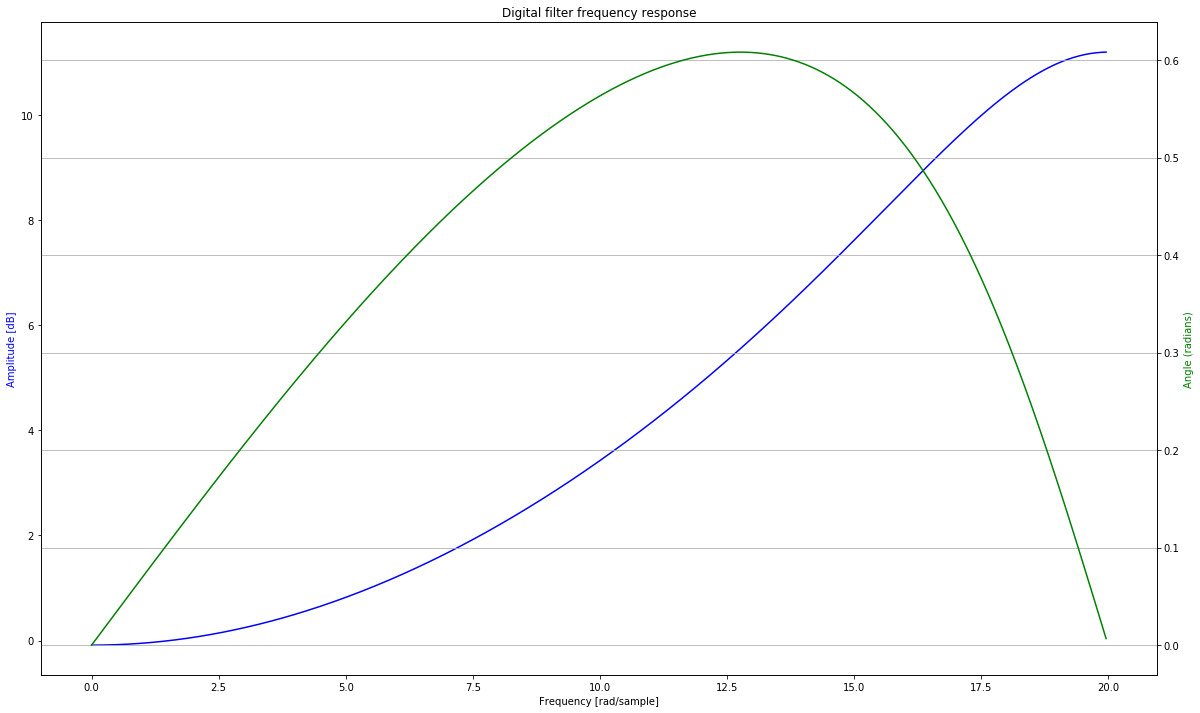

In [309]:
doplot(tf_b, tf_a)

In [310]:
# This filter (attempts to) compensate for phase distortion from the 2-pole elliptical filter
# on the DD 3.0 board.  It still needs some development work, but a little phase adjustment
# goes a long way to improve colors
def calculate_dd_filter(params):
    filterdata = pd.read_csv('dd30phase.csv').iloc[:]
    # add an ending to try to keep freq response closer to even
    filterdata.loc[65] = [20000000, 144]

    ffreq = (filterdata.hz / (params['freq_hz'] / 2)) * np.pi

    fphase = (filterdata.phase) * (np.pi / 180)
    flevela = np.ones_like(fphase)

    fphase[58:] += (np.pi* 2)

    cut = 0
    cutend = len(ffreq)-0
    _level = 1
    _shift = -.02
    dimb = 1
    dima = 3
    [fb, fa] = fdls.FDLS(dimb, dima, ffreq[cut:cutend], np.ones_like(ffreq[cut:cutend]), fphase[cut:cutend]*_level, shift=_shift)

    return fb, fa



In [311]:
# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    blocklen = params['blocklen']
    print(blocklen)
    
    SP['hilbert_filter_terms'] = hilbert_filter_terms
    
    # build up a couple more constants
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF filter, which will get the audio notch filters added if needed
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'), blocklen)
    
    # If there is analog audio, it must be filtered well especially with DD >=3.0-beta RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'), blocklen)
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    #tmp = filtfft([fb, fa], blocklen)
    #SP['FRFVideo'] *= tmp
    
    #SP['FRFVideo'] *= exp
    
    SP['Fhilbert'] = np.fft.fft(hilbert_filter, blocklen)
    
    SP['Fdd'] = filtfft(calculate_dd_filter(SP), blocklen)
    
    # This MTF filter needs A LOT of work!
    [tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.65)
    SP['Fmtf'] = filtfft([tf_b, tf_a], blocklen)
    
    # The above is multiplied with a Hilbert transform to get (partway) to demodulation
    
    # The 4.2-4.6mhz (NTSC)/5.x mhz (PAL) demodulated lowpass filter
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low'), blocklen) # standard 4.Xmhz

    # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10), -SP['deemp'][0]*(10**-10), SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)

    # The direct opposite of the above, used in test signal generation
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10)/2.0, -SP['deemp'][1]*(10**-10)/2.0, SP['deemp'][1] / SP['deemp'][0])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10), -SP['deemp'][1]*(10**-10), SP['deemp'][1] / SP['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half), blocklen)
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(4, 0.5/freq_half, 'low'), blocklen) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fburst_len'] = int(np.ceil((18 * freq_half / SP['fsc_mhz']) / 2) * 2)
        SP['Fburst_delay'] = SP['Fburst_len'] // 2
        print(SP['Fburst_len'])
        bf = sps.firwin(SP['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fburst'] = filtfft((bf, [1.0]), blocklen)
        SP['imglen'] = (int)((SP['freq_hz'] / 59.976) * 1.25)
    else:
        # For PAL this is a 3.75mhz filter
        SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f, blocklen)
    print(SP['FPsync'].shape)
    
    return SP

In [312]:
# The actual video demodulation code

def dodemod(paramsc, data, mtf_level = 0, dd_level = 1.0, cutarf = False, return_fft = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if mtf_level != 0:
        indata_fft_filt *= paramsc['Fmtf'] ** mtf_level

    if dd_level != 0:
        indata_fft_filt *= paramsc['Fdd'] ** dd_level
        
        
    hilbert = np.fft.ifft(indata_fft_filt * paramsc['Fhilbert'])

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * paramsc['FPsync']).real
    
    rv = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    if return_fft:
        return rv, indata_fft_filt, demod_fft
    else:
        return rv
    #return out_video, out_video05, out_videoburst

In [313]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9850000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [314]:
# note: currently returns PSNR assuming IRE==100
def calcsnr(a):
    #stdire = np.std(a) / NTSC_hz_ire
    #return(20 * np.log10(100 / stdire))
    
    signal = hztoire(np.mean(a))
    noise = np.std(a) / hz_ire_scale
    #print(signal, noise)
    return 20 * np.log10(70 / noise)


In [315]:
# Scaler code in Python is horribly slow - numpy is a bit less so

# Thankfully for bit unpacking there are numpy routines to operate on bit arrays...
def load_packed_data(infile, sample, readlen = blocklen):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(readlen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    # By using strides the unpacked data can be loaded with no additional copies
    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    # hold the shifted bits in it's own array to avoid an allocation
    tmp = np.right_shift(indata, 10)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[1::3])
    np.right_shift(indata, 20, out = tmp)
    np.bitwise_and(tmp, 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + blocklen]

In [316]:
def loaddata(infile, sample):

    # packed data is a bit more complicated
    if sampletype == 3:
        return load_packed_data(infile, sample)

    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(blocklen * sampletype)

    if sampletype == 2:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    else:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
    return indata


In [317]:
def demod(infile, _start, _end, filterset, mtf_level = 0.0, dd_level = 1.0, retraw = False):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = int(_end)
    
    if (_start > blockcut):
        start = int(_start - blockcut)
    else:
        start = 0 # should this be an error?  prolly.

    #print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        indata = loaddata(infile, i)
        if indata is None:
            break
        
        tmp = dodemod(filterset, indata, mtf_level, dd_level)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    if retraw:
        return output, indata
    else:
        return output
    

In [318]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [319]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out

In [320]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(filterset['blocklen'], dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    #[tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    #filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode = dodemod(filterset, fakesignal)

    # Determine filter lag (mostly the length of the hilbert filter)
    filterset['dgap'] = calczc(fakedecode['demod'], 950, iretohz(-20), 256 + hilbert_filter_terms) - calczc(fakeoutput_emp, 950, iretohz(-20), 500)

    # Now use above to calc the lag of the 0.5mhz filter
    dgap05_1 = calczc(fakedecode['demod_05'], 900 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 900 + filterset['dgap'], iretohz(-20), 500)
    dgap05_2 = calczc(fakedecode['demod_05'], 1250 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 1250 + filterset['dgap'], iretohz(-20), 500)
    filterset['dgap_05'] = (dgap05_1 + dgap05_2) / 2

    fdburst_adj = fakedecode['demod_burst'][filterset['Fburst_delay']:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - ((filterset['freq'] / 2) / (315/88)) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * ((filterset['freq'] / 2) / (315/88)) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), 8100000)
    filterset['dgap_burst'] = (c17 - c17_demod)

    # not what we actually want ;)
    #filterset['dgap_burst'] = (c17 - c17_orig) - filterset['dgap']

    return fakeoutput, fakedecode

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [321]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        #endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
        endsync1 = center + np.where(syncf[center:center + scanarea] > .95)[0][-1]
        endsync = endsync1 + np.where(syncf[endsync1:endsync1 + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')
        return None

    try:
        scanstart = (startsync - (ilinepx * 9))
        lastlinepresync = scanstart + np.where(syncf[scanstart: startsync] > .6)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line", startsync)
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .6)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line", endsync)
        nextline = None
        postsync_eqlen = None

    #print(lastlinepresync, nextline, presync_eqlen, postsync_eqlen)
    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

#findburstfromsync(rdata['demod_sync'], 190301)

In [322]:
def findsync(output_sync, loc = 0, limit = 40 * 2800):
    loc = int(loc)

    # find the next sync point.  should be > .9
    syncloc = np.argmax(output_sync[loc:loc+limit]) + loc

    if np.max(output_sync[loc:loc+limit]) < .9:
        #print("oops.  can't find a good sync")
        return (None, None, None)
    
    rv = findburstfromsync(output_sync, syncloc)
    if rv is None:
        return None, None, None
    
    prevline, nextline, pregap, postgap = rv

    #print(np.max(output_sync[loc:loc+imglen]), pregap, postgap)
    
    if pregap >= 3.75:
        firstfield = False
    else:
        firstfield = True
    
    return syncloc, firstfield, nextline

In [323]:
def findfirstframe(infile, start = 0):

    readlen = int(128 * filterset['line_px'])

    loc = start
    while (loc - start) < filterset['freq_hz']:
#        print(loc)
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
            if (np.argmax(data['demod_sync']) / filterset['line_px']) < 16:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                continue
        else:
            loc += int(120 * filterset['line_px'])
            continue
                
        #print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        #print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and firstfield:
            loc += int(240 * filterset['line_px'])
            #return loc + nextline, data
        elif syncloc and not firstfield:
            return loc + nextline, data
        else:
            loc += int(120 * filterset['line_px'])
    
    return None

In [430]:
# note:  this VBI decoder works with unscaled lines.
def decodephillipscode(data, linestart):
    print(linestart)
    curzc = calczc(data, int(linestart + usectopx(2)), iretohz(50), int(usectopx(12)))

    zc = []
    while curzc is not None:
        zc.append((curzc, data[int(curzc - usectopx(0.5))] < iretohz(50)))
        curzc = calczc(data, curzc+usectopx(1.9), iretohz(50), int(usectopx(0.2)))

    usecgap = pxtousec(np.diff([z[0] for z in zc]))
    valid = len(zc) == 24 and np.min(usecgap) > 1.85 and np.max(usecgap) < 2.15

    if valid:
        bitset = [z[1] for z in zc]
        linecode = []
        for b in range(0, 24, 4):
            linecode.append((np.packbits(bitset[b:b+4]) >> 4)[0])
        #print(bitset)
        print(linecode)
        return linecode
    else:
        return None
    
def processphillipscode(data, lines):
    rv = {'codes': []}
#    codes = []
    for l in range(6, 10):
        lc = decodephillipscode(data, lines[l])
        if lc is not None:
            rv['codes'].append((l, lc))
            if lc[0] == 15: # frame code
                if lc[2] == 13: # CLV
                    print('CLV')
                    rv['frame'] = -1
                else: # CAV
                    frame = (lc[1] & 7) * 10000
                    frame += (lc[2] * 1000)
                    frame += (lc[3] * 100)
                    frame += (lc[4] * 10)
                    frame += lc[5] 
                    print('CAV frame #', frame)
                    rv['frame'] = frame
                    
    return rv

In [431]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [432]:
def downscale_field(data, lineinfo, outwidth=1820):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor

In [433]:
# first round of building up line locations using the low-passed sync status
def buildlinelocs_sync(field, filterset, start):
    output = field['demod']
    output_sync = field['demod_sync']
    ilinepx = int(filterset['line_px'])

    syncloc1, firstfield, curloc = findsync(frame['demod_sync'], start)

    lineinfo = [curloc]
    for i in range(0, 253):
        prevloc = curloc

        curloc += int(filterset['line_px'] * .9)
        offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
        curloc += offset 

        # if the sync detection burst doesn't look good, reuse the last one
        is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
        validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
        if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
            if i < 252:
                print("bad sync", i, curloc)
            curloc = prevloc + (lineinfo[-1] - lineinfo[-2])

        #rint("bls ", i, curloc, output[curloc], output[curloc+8])

        lineinfo.append(curloc)
    
    return lineinfo

# finds where each hsync crosses the 20 IRE boundary
# (this could use the 0.5mhz LPF, but it seems ok even w/level 4 rot disks not to)
def buildlinelocs_rise(field, lineinfo, filterset):
    output = field['demod']
    crossire = iretohz(-20)

    lineinfo2 = []
    for l in lineinfo:
        zc = calczc(output, l - 5, crossire, 200) 
#        print("lrr ", l, zc)

        # on rotted disks, it's quite possible that 
        if zc is None or (output[int(zc) + 10] < crossire):
            # make a wild guess?  FIXME?
            lineinfo2.append(l + (2 * ((ilinepx / 910))))
            continue

        # now use the previously calculated 0.5mhz adjustment
        lineinfo2.append(zc)

    # correct the first line
    lineinfo2[0] = lineinfo2[1] - (lineinfo2[2] - lineinfo2[1])

    return lineinfo2


In [434]:
def array_inrange(a, mi, ma):
    return ((np.sum(a >= mi) + np.sum(a <= ma)) == a)

# check hsyncs and color burst quality.  Any spikes in either will cause
# the line to be ignored and location interpolated.

def checklinelocs(frame, lineinfo, filterset, outfsc):
    lineinfo2 = lineinfo.copy()
    output = frame['demod']
    outwidth = int(outfsc * 227.5)
    
    def _usectopx(px):
        return (outwidth * px) / 63.55
    
    def usectopx(usec, freq = filterset['freq_hz']):
        return freq * usec / 1000000    
    
    badburst = np.zeros_like(lineinfo2, dtype=np.int)

    for l in range(1, len(lineinfo2) - 1):
        # Check the quality of the hsync area before the line starts 
        # (XXX:  don't need the whole line!)
        scaled = scale(output, lineinfo2[l - 1], lineinfo2[l], outwidth) 
        subset = scaled[int(outwidth - (outfsc * 15)):outwidth]
        if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
            badburst[l] = 1
            continue

        tgtsync = _usectopx(58.35)
        syncstart = calczc(scaled, tgtsync, iretohz(-20), _usectopx(2.5))
        if np.abs(syncstart - _usectopx(58.85)) > (outwidth * 0.5 / 63.55):
            subset_endsync = scaled[int(syncstart - _usectopx(1.0)):int(syncstart + _usectopx(1.0))]
            #print(l, len(subset_endsync))
            if (np.max(subset_endsync) > iretohz(35)) or (np.min(subset_endsync) < iretohz(-50)):
                print('err ', l, syncstart - _usectopx(1.0))
                badburst[l] = 1
                continue
            else:
                print(l, ' correction factor', (syncstart - _usectopx(58.85)) * (ilinepx / outwidth))
                lineinfo2[l] -= (syncstart - _usectopx(58.85)) * (ilinepx / outwidth)
        
        # check the end hsync location (XXX: ditto)
        scaled = scale(output, lineinfo2[l], lineinfo2[l + 1], outwidth) 
        
        # For NTSC, the end location should be at approx 58.85usec.
        # Fix it if it's a clean sample and outside of that...
        syncstart = calczc(scaled, tgtsync, iretohz(-20), _usectopx(4.0))
        #print(l, syncstart, _usectopx(58.85))

        if syncstart is None:
            badburst[l] = 1
            continue
        
        # color burst check
        subset = scaled[int(outfsc*1.5):int(outfsc*15)]

        if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
            badburst[l] = 1
            
    return lineinfo2, badburst

In [435]:
# note:  i hacked this off buildfield, which is why it's a bit clumsy atm ;)
def cburstalign(frame, lineinfo, badburst, shift33 = -((33.0 / 360.0) * np.pi)):
    lineinfo_tmpa = lineinfo.copy()
    offset = 0
    
    output = frame['demod']
    output_burst = frame['demod_burst']
    
    peak = []
    cuts = []
    for l in range(0, len(lineinfo_tmpa) - 1):
        if badburst[l]:
            #lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue
        
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()
        
        peak.append(np.argmax(np.abs(cut)))
        
    peak = np.array(peak)
    peakmean = peak.mean()
    
    zc = []
    linelens = []
    for l in range(0, len(lineinfo_tmpa) - 1):
        if badburst[l]:
            continue

        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        #zc.append(calczc(cut, np.floor(peakmean), 0, 5))
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        try:
            zc.append(calczc(cut, np.floor(peakmean), 0, 5) * (outwidth / linelen))
            linelens.append(lineinfo_tmpa[l + 1] - lineinfo_tmpa[l])
        except:
            None
        
    #print("zcmean ", np.mean(zc), np.mean(zc) * (outwidth / np.mean(linelens)))
        
    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(0, len(lineinfo_tmpa) - 1):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(3.5))].copy()
        cut -= cut.mean()

        try:
            adjpeak = (calczc(cut, np.argmax(np.abs(cut)), 0) + filterset['dgap_burst']) * (outwidth / linelen)
        except:
            print('bad burst', l, lineinfo[l], lineinfo2[l], tmp)
            badburst[l] = True
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offsets[l - 1] - filterset['dgap_burst']
            continue

        # find the nearest odd # for the peak crossover.
        target = (np.round((adjpeak - 1) / 2) * 2) + 1
        offsets[l] = (adjpeak - target)

        #print('fs ', l, np.argmax(cut), adjpeak, target,  offsets[l], lineinfo2[l], lineinfo_tmpa[l], lineinfo_tmpa[l] - lineinfo_tmpa[l - 1])
            
    if np.mean(np.abs(offsets)) > .8:
        print("WARNING: offsets too high")
            
    # outlier repair.  TODO:  handle more than one outlier line in a row?
    for l in range(2, len(lineinfo_tmpa) - 2):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.2) and (np.abs(offsets[l] - offsets[l + 1]) > 1.2):
            print("outlier repair ", l, offsets[l - 1:l + 2])
            if offsets[l] > 0:
                offsets[l] -= outfsc // 2
            else:
                offsets[l] += outfsc // 2
            print("outlier repair ", l, offsets[l])
            
    #shift33 = -((33.0 / 360.0) * 4)  # this is too much for current comb-ntsc
    #shift33 = -((33.0 / 360.0) * 2.45)
    
    lineinfo_cphaseadj = lineinfo_tmpa.copy()
    for l in range(0, len(lineinfo_tmpa) - 1):
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offsets[l]  * (linelen / outwidth)) #- filterset['dgap_burst']    
        lineinfo_cphaseadj[l] =  lineinfo_tmpa[l] + (shift33 * (linelen / outwidth)) #- filterset['dgap_burst']    

    return lineinfo_tmpa, lineinfo_cphaseadj, offsets

def buildfield(frame, start = 0, phaseshift = 0, outfsc = 4, shift33 = -((33.0 / 360.0) * np.pi)):
    ilinepx = int(filterset['line_px'])
    outwidth = int(227.5 * outfsc)
    
    output = frame['demod']
    output_sync = frame['demod_sync']
    output_lp = frame['demod_05']
    output_burst = frame['demod_burst']

    lineinfo = buildlinelocs_sync(frame, filterset, start)
    lineinfo2 = buildlinelocs_rise(frame, lineinfo, filterset)
    
    # now for fine sync - verify what we've got so far
    lineinfo2, badburst = checklinelocs(frame, lineinfo2, filterset, outfsc)

    # and finer sync using color burst

    lineinfo_tmpa, lineinfo_cphaseadj, offsets = cburstalign(frame, lineinfo2, badburst, shift33)
    
    # XXX: should be able to compute this earlier.  need to know which burst we're looking at though!
    burstphase = []
    field_cburst, sfactor = downscale_field(output_burst[filterset['Fburst_delay']:], lineinfo_tmpa, outwidth)
    for i in range(0, len(lineinfo_tmpa)):
        fcb29 = field_cburst[int((i * outwidth) + ((outfsc * 7.25) + 1))]
        fcb_mean = np.mean(field_cburst[int((i * outwidth) + (outfsc * 2.5)):int((i * outwidth) + (outfsc * 12.5))])
        burstphase.append((fcb29 > 0, (np.fabs(fcb29 - fcb_mean) * .85) / hz_ire_scale))

    field, sfactor = downscale_field(output, lineinfo_cphaseadj, outwidth)

    return field, lineinfo_tmpa, burstphase, zc, lineinfo2
    


In [436]:
def pxtousec(px, freq = 40000000):
    return (px / freq) * 1000000

def usectopx(usec, freq = 40000000):
    return freq * usec / 1000000

def formatoutput(lines_odd, lines_even, lines_odd_cburst, lines_even_cburst):
    outwidth = 910

    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 503, 2):
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = lines_even[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]
        combined[((i + 1) * outwidth):((i + 2) * outwidth)] = lines_odd[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]

    reduced = (combined - minn) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

    for i in range(0, 504, 2):
        if not lines_even_cburst[i // 2][0]:
            lines16[((i + 0) * outwidth)] = 16384
        else:
            lines16[((i + 0) * outwidth)] = 32768

        clevel = .58

        lines16[((i + 0) * outwidth) + 1] = np.uint16(327.67 * clevel * lines_even_cburst[i // 2][1])

        if not lines_odd_cburst[i // 2][0]:
            lines16[((i + 1) * outwidth)] = 16384
        else:
            lines16[((i + 1) * outwidth)] = 32768

        lines16[((i + 1) * outwidth) + 1] = np.uint16(327.67 * clevel * lines_odd_cburst[i // 2][1])

    #drawdata(lines16, outwidth, 506, hscale=2, vscale=2)
    
    frameout = np.zeros((844 * 505), dtype=np.uint16)
    offset = -8

    for i in range(1, 505):
        frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]
        frameout[(i + 0) * 844: ((i + 0) * 844) + 2] = lines16[((i + 0) * 910): ((i + 0) * 910) + 2]

    #outfile = open('tmp.tbc', 'wb')
    #outfile.write(frameout)
    
    return combined, lines16, frameout

In [437]:
if True: # DD 3.0
    params['freq'] = 40.0
    
    deemp_adj1 = .35
    deemp_adj2 = .35

    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)

    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 2
    params['vlpf_freq'] = 4400000
    params['vlpf_order'] = 5    

    # use w/ac3 disks
    #params['audio_rfreq'] = 2900000

filterset = prepare_video_filters(params)
dg = calc_demodgaps(filterset)
imglen = filterset['imglen']

16384
102
(16384,)


In [438]:
firstloc = 1024 * 1024 * 300
#infile = open('/home/cpage/ilovela.raw', 'rb')
#infile = open('/home/cpage/ldcaps3/erica.raw', 'rb')
#infile = open('/mnt2/ld/st6-praxis.raw', 'rb')
#infile = open('/home/cpage/avs50819.raw', 'rb')
#infile = open('/home/cpage/ldcaps3/ve_tp.raw', 'rb')
#infile = open('/mnt2/ld/giu8x.raw', 'rb')
#infile = open('/mnt2/ld/dd/he010_6x-ch4.raw', 'rb')
#infile = open('/mnt2/ld/ggv1001-s1.r30', 'rb')
infile = open('/mnt2/ld/ve-test.r30', 'rb')
#firstloc = 1024 * 1024 * 50000 # frame 39288
#firstloc = 1024 * 1024 * 68000 # frame 53430

#infile = open('/mnt2/ld/ve-test.r30', 'rb')
#infile = open('/home/cpage/videosketches.raw', 'rb')
sampletype = 3

In [439]:
outfsc = 4
outwidth = int(outfsc * 227.5)

ilinepx = filterset['line_px']

needmtf = 0
rdata = None

while rdata is None:
    firstloc, rdata = findfirstframe(infile, firstloc)
    print('d', firstloc)
    if firstloc < (25 * ilinepx):
        firstloc += (25 * ilinepx)
        rdata = None

d 314837721


In [442]:
start = firstloc - (24 * ilinepx)

outfd = open('vs2.tbc', 'wb')

shift = -((33.0 / 360.0) * np.pi)

havefirstfield = False
fcount = 0
while fcount < 1:
#for f in range(0,1):
    dd_level = 0
    frame = demod(infile, start, start + int(800 * filterset['line_px']), filterset, needmtf, dd_level)
    fs = findsync(frame['demod_sync'], 0)
    print(fs)

    ilinepx = int(filterset['line_px'])

    syncloc1, firstfield, line1 = findsync(frame['demod_sync'], 0)
    print(syncloc1, firstfield, line1)

    # need a margin before sync peak
    start1 = syncloc1 - int(15 * filterset['line_px'])
    print(start, start1)
    lines_even, lineinfo_even, lines_even_cburst, zc, le1 = buildfield(frame, start1, outfsc=outfsc)
    vbiinfo = processphillipscode(frame['demod'], lineinfo_even)
    
    #havefirstfield=True
    if 'frame' in vbiinfo:
        havefirstfield = True
    elif havefirstfield:
        combined, output_fullframe, output_cropped = formatoutput(lines_odd, lines_even, lines_odd_cburst, lines_even_cburst)
        fcount += 1
        outfd.write(output_cropped)
        havefirstfield = False
    
    syncloc2, secondfield, line2 = findsync(frame['demod_sync'], int(lineinfo_even[-20]))
    print(syncloc2, secondfield, line2)

    start2 = syncloc2 - int(15 * filterset['line_px'])
    lines_odd, lineinfo_odd, lines_odd_cburst, zco, lo1 = buildfield(frame, start2, outfsc=outfsc)
    vbiinfo = processphillipscode(frame['demod'], lineinfo_odd)

    if 'frame' in vbiinfo:
        havefirstfield = True
    elif havefirstfield:
        combined, output_fullframe, output_cropped = formatoutput(lines_odd, lines_even, lines_odd_cburst, lines_even_cburst)
        fcount += 1
        outfd.write(output_cropped)
        havefirstfield = False
    
    prevstart = start
    start = start + int(lineinfo_odd[-30])
    #print(start)

(53019, False, 60962)
53019 False 60962
314776761 14919
76277.9927924
[8, 11, 10, 4, 4, 11]
78820.3980151
[15, 3, 0, 1, 5, 0]
CAV frame # 30150
81362.7504014
[15, 3, 0, 1, 5, 0]
CAV frame # 30150
83905.1553618
716688 True 729714
745024.956977
[8, 11, 10, 4, 4, 11]
747566.74635
[8, 9, 5, 13, 13, 13]
750108.385255
[8, 9, 5, 13, 13, 13]
752650.021005


(460460,)
uint8 (506, 910) (506, 910)


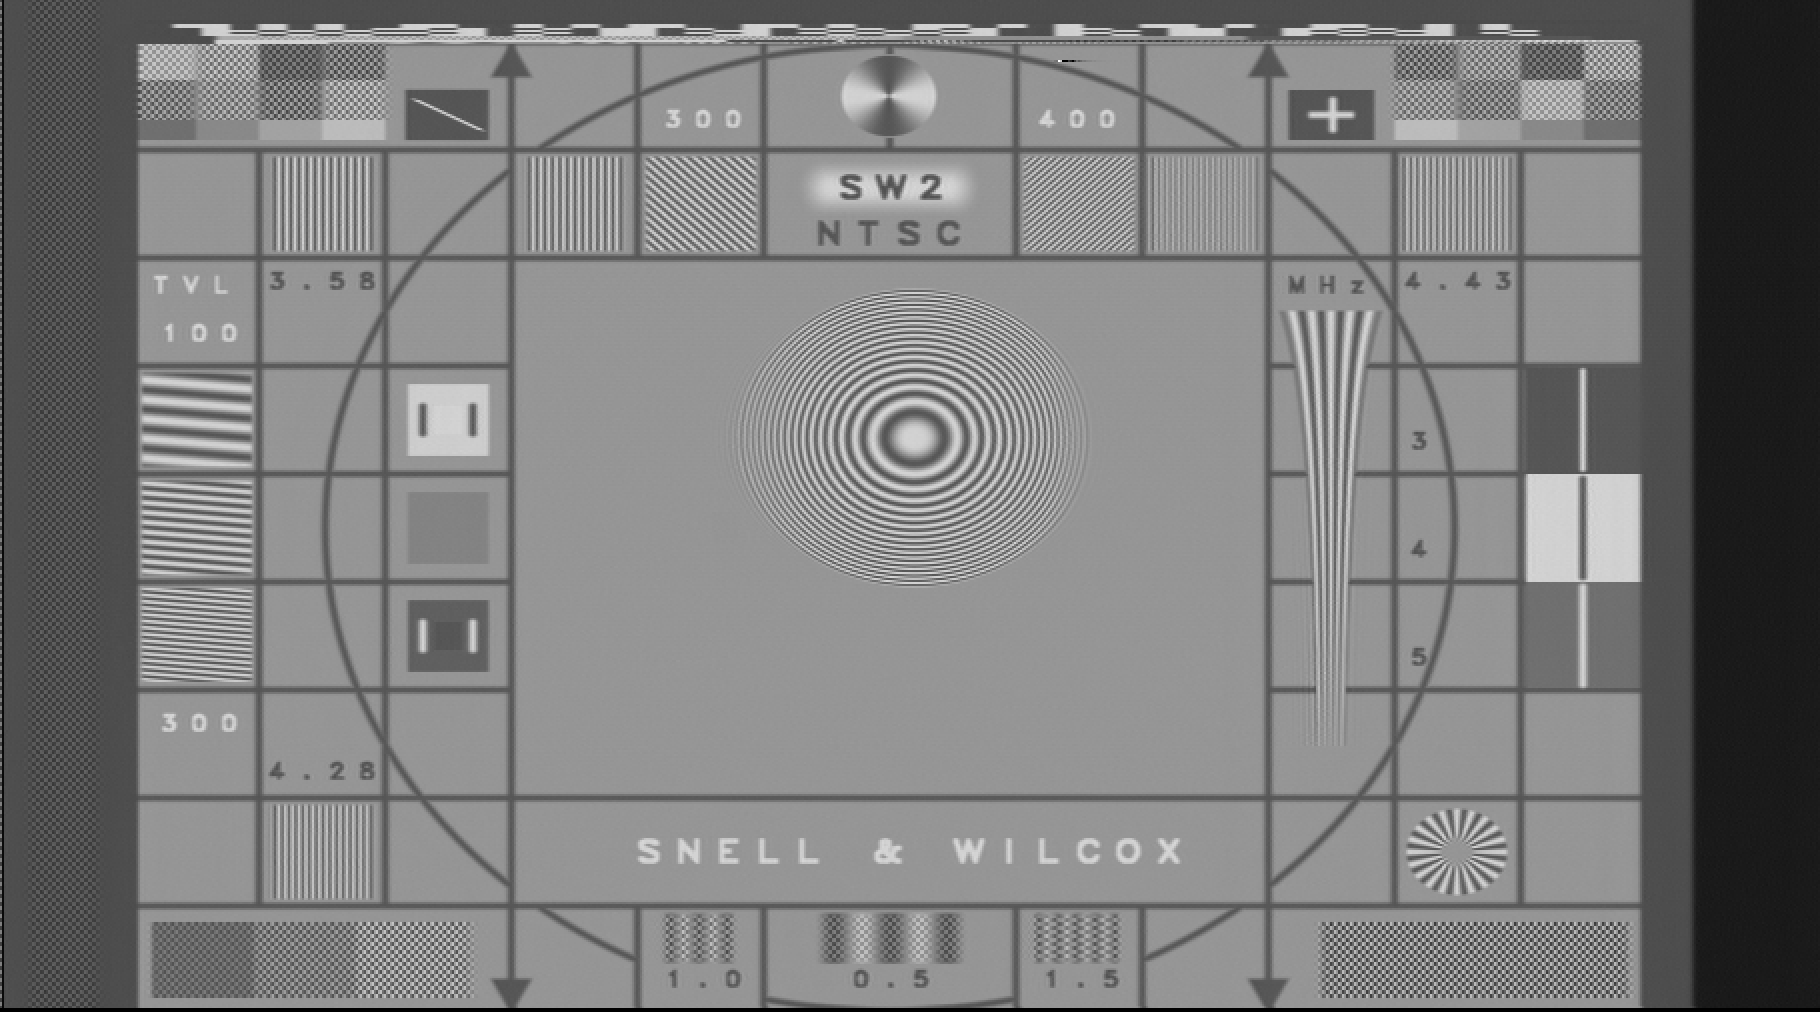

In [441]:
drawdata(output_fullframe, outwidth, 506, hscale=2, vscale=2)

3.53572880393 28.6157658971
3.53572880393 3.82795104016 38.6814676496


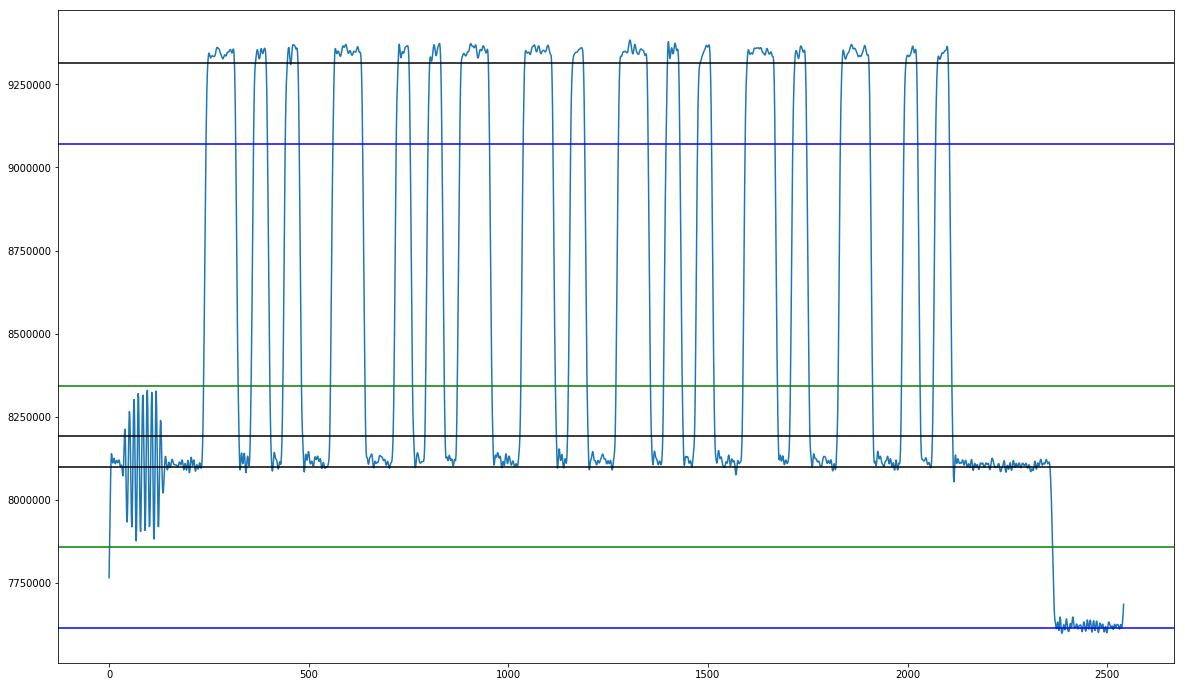

In [419]:
l = 6

bar0 = frame['demod'][int(lineinfo_even[l]):int(lineinfo_even[l+1])]
#bar0 = frame['demod'][int(lineinfo_odd[l]):int(lineinfo_odd[l+1])]
lineplot(bar0, filterset)
print(calcsnr(bar0[400:600]), (np.max(bar0[1200:1500]) - 8100000) / (bar0[500] - 8100000))
print(calcsnr(bar0[400:600]), calcsnr(bar0[1040:1150]), calcsnr(bar0[-150:-10]))


In [427]:
usectopx(4)

160.0

In [39]:
outline = output_fullframe[2+20*910:21*910]
white = outline[120:320]

In [690]:
20*np.log10(70/.91512)

37.672399860579603

In [679]:
.43356/100

0.0043356

In [688]:
np.mean(white), np.std(white) / out_scale

(52120.875, 0.91512904176031196)

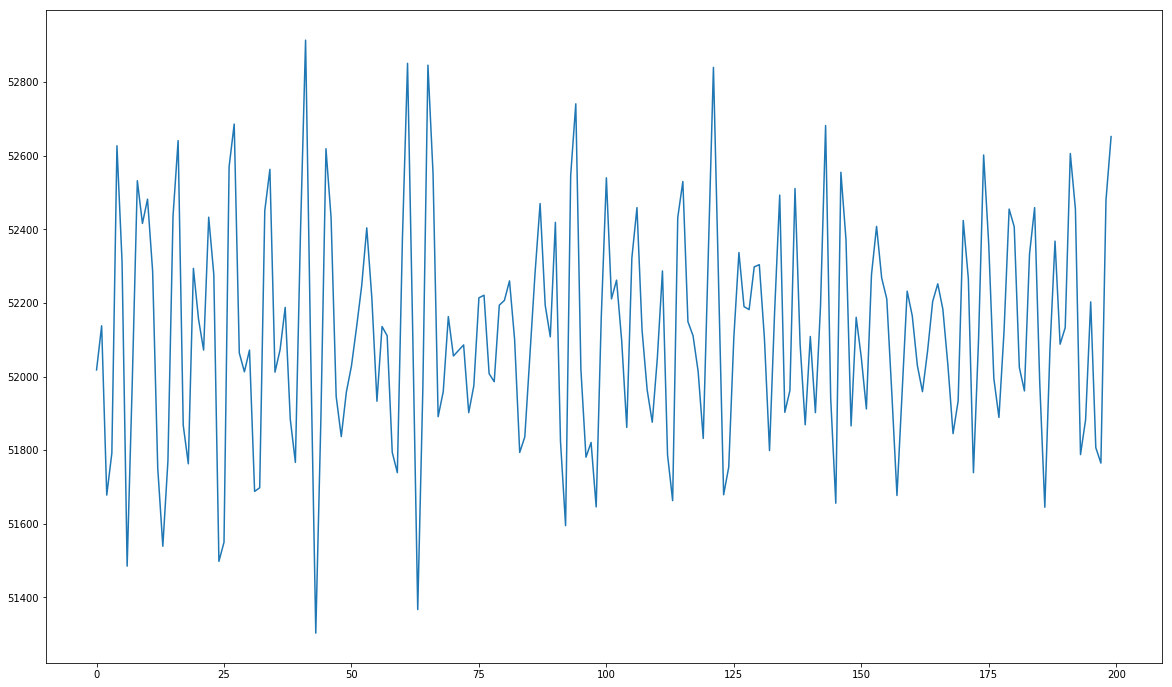

In [689]:
plt.plot(outline[120:320])

12.6902774822 1.447661916
12.6902774822 20.0237034756 41.3467585674


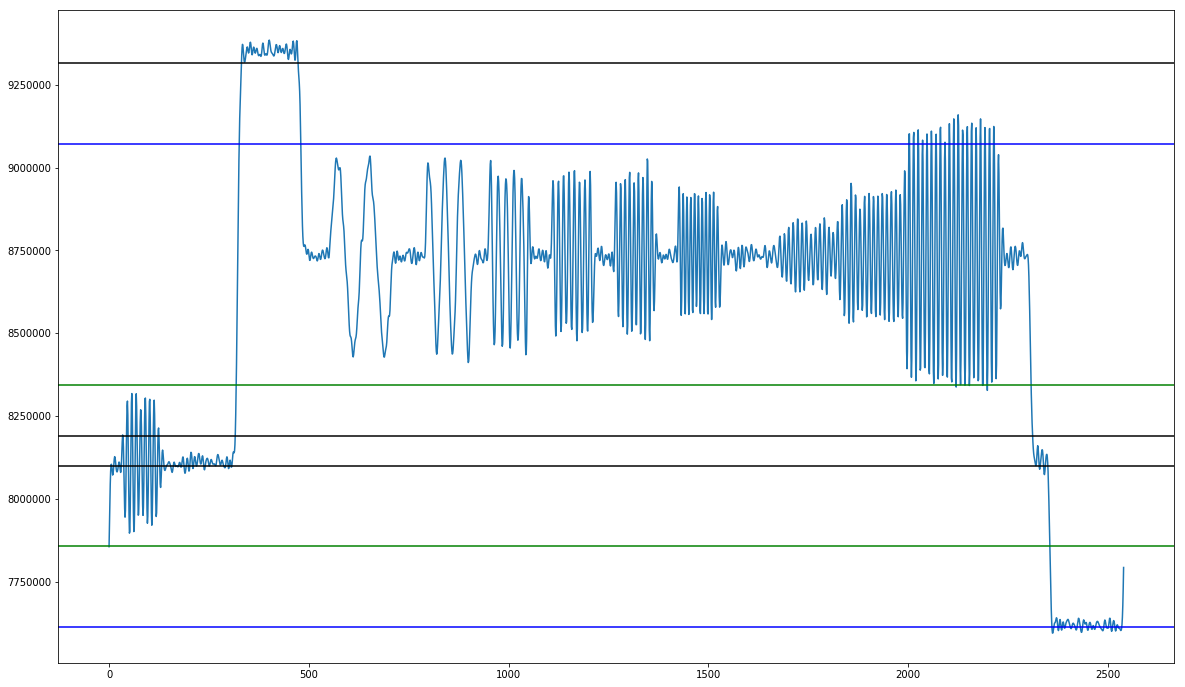

In [514]:
l = 10

bar0 = frame['demod'][int(lineinfo_odd[l]):int(lineinfo_odd[l+1])]
lineplot(bar0, filterset)
print(calcsnr(bar0[400:600]), (np.max(bar0[1200:1500]) - 8100000) / (bar0[500] - 8100000))
print(calcsnr(bar0[400:600]), calcsnr(bar0[1040:1150]), calcsnr(bar0[-150:-10]))


In [138]:
fb = [1.0]
fa = [1.0]

<-3db crossing at  4.1796875
>-3db crossing at  12.65625
>3db crossing at  15.625


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


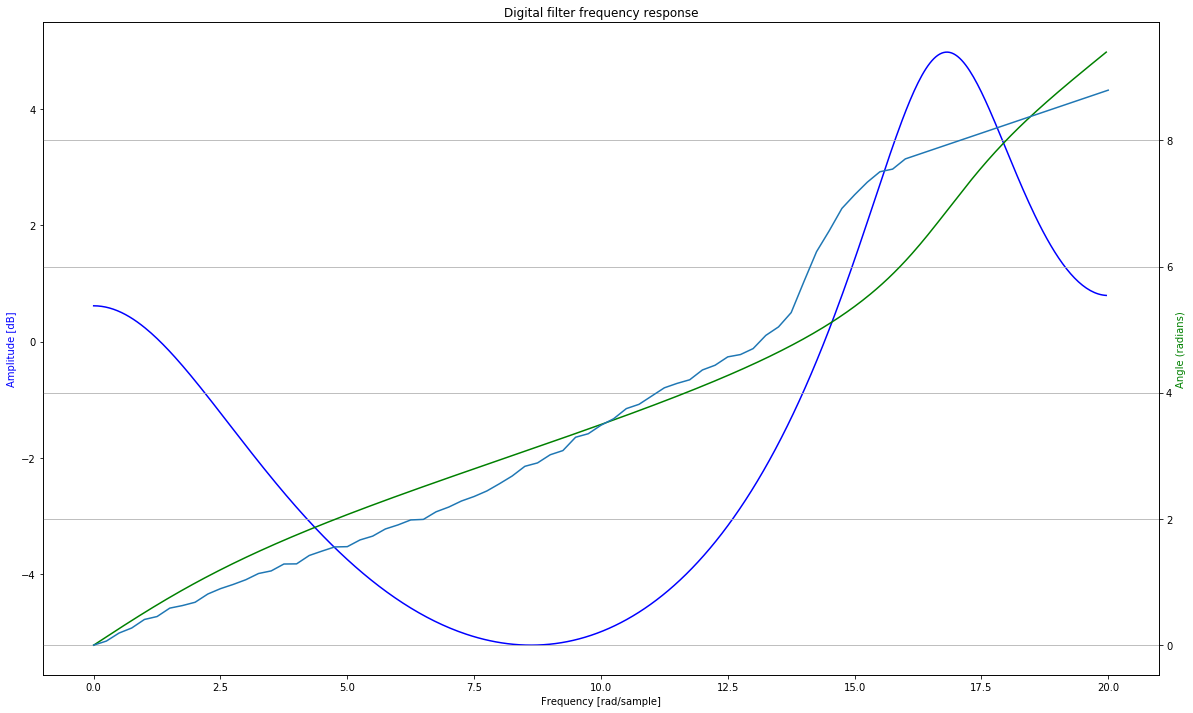

In [42]:
## This filter (attempts to) compensate for phase distortion from the 2-pole elliptical filter
# on the DD 3.0 board.  It still needs some development work, but a little phase adjustment
# goes a long way to improve colors
filterdata = pd.read_csv('dd30phase.csv').iloc[:]
# add an ending to try to keep freq response closer to even
filterdata.loc[65] = [20000000, 144]

ffreq = (filterdata.hz / 20000000) * np.pi

fphase = (filterdata.phase) * (np.pi / 180)
flevela = np.ones_like(fphase)

fphase[58:] += (np.pi* 2)

cut = 0
cut2 = len(fphase)-0
#[fb, fa] = fdls.FDLS(2, 1, ffreq[cut:], np.ones_like(ffreq[cut:]), fphase[cut:]*.65, shift=.525)
[fb, fa] = fdls.FDLS(2, 1, ffreq[cut:cut2], flevela[cut:cut2], fphase[cut:cut2]*.65, shift=.7)
[fb, fa] = fdls.FDLS(1, 2, ffreq[cut:cut2], flevela[cut:cut2], fphase[cut:cut2]*.65, shift=.7)

# ~1.0x with ok noise...

[fb, fa] = fdls.FDLS(3, 3, ffreq[cut:cut2], flevela[cut:cut2], fphase[cut:cut2] * 1, shift=0)

# pretty nice
[fb, fa] = fdls.FDLS(1, 3, ffreq[cut:], np.ones_like(ffreq[cut:]), fphase[cut:]*1, shift=0)

# also nice
[fb, fa] = fdls.FDLS(1, 3, ffreq[cut:], np.ones_like(ffreq[cut:]), fphase[cut:]*1, shift=0.2)

# think i'll go with this one :)
[fb, fa] = fdls.FDLS(1, 3, ffreq[cut:], np.ones_like(ffreq[cut:]), fphase[cut:]*1, shift=0.28)


# Do a plot now... the drop in amplitude probably isn't helping IRE100 SNR.
doplot(fb, fa, extra = [filterdata[cut:cut2].hz / 1000000, fphase[cut:cut2]])
#plt.plot(filterdata.hz / 1000000, fphase[cut:])



8192
102
(8192,)
268
16.0869417613 0.987354913755
16.0869417613 0.987354913755
16.0869417613 15.9864405491 39.6558891956
16.0869417613 15.9864405491 39.6558891956


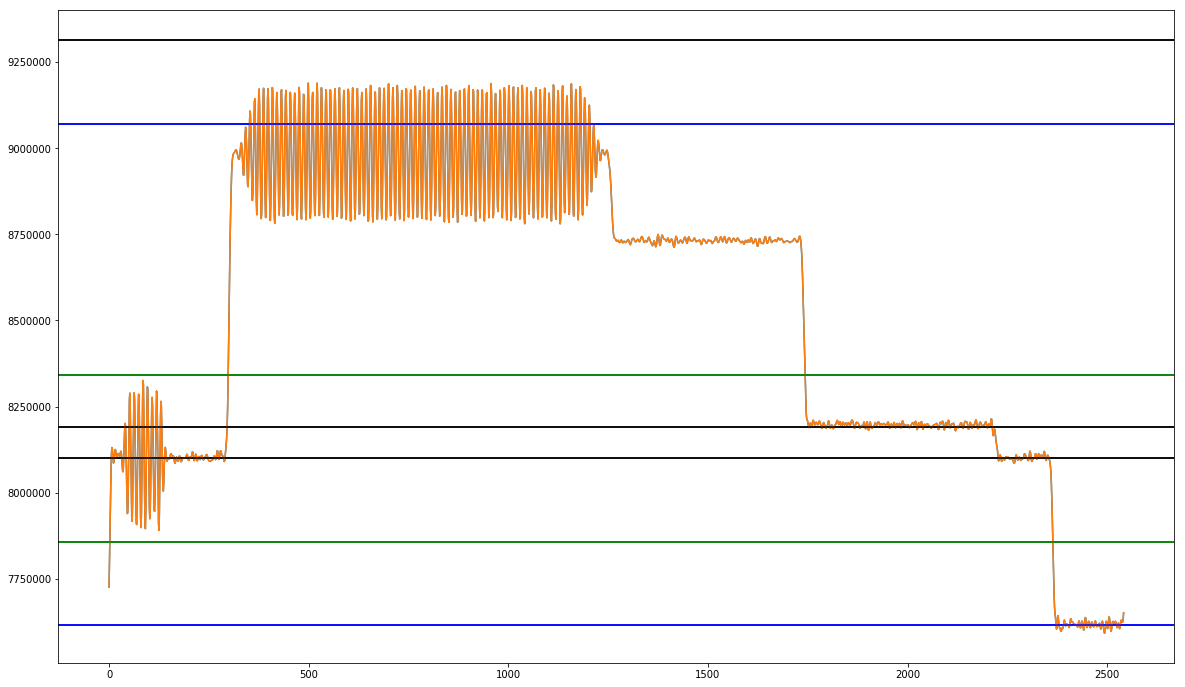

In [379]:
params_short = copy.deepcopy(params)
params_short['blocklen'] = 8192

deemp_adj1 = .35
deemp_adj2 = .35
params_short['deemp'] = (120*deemp_adj1, 320*deemp_adj2)

params_short['vbpf'] = (3500000, 13500000)
params_short['vbpf_order'] = 2
params_short['vlpf_freq'] = 4200000
params_short['vlpf_order'] = 5

params_short['audio_filtwidth'] = 350000
params_short['audio_filtorder'] = 3

filterset_short = prepare_video_filters(params_short)
calc_demodgaps(filterset_short)

#[fb, fa] = fdls.FDLS(1, 3, ffreq[cut:], np.ones_like(ffreq[cut:]), fphase[cut:]*1, shift=0.28)
filterset_short['Fdd'] = filtfft([fb, fa], params_short['blocklen'])

# use above to decode even lines 9/10.  These are VITS lines there on all 
# disks compliant with the LD standard (but NOT discovisions - they're confused)
l = 9
demods_offset = int((filterset_short['dgap'] * 2))
print(demods_offset)
# make sure the first line begins in a sync
syncgap = int(usectopx(2))
indata_tmp = loaddata(infile, int(prevstart) + int(lineinfo_even[l]) - demods_offset - syncgap)
linelen_short = int(lineinfo_even[l+1] - lineinfo_even[l])

needmtf = 0
dd_level = 0
demod_short = dodemod(filterset_short, indata_tmp[0:8192], needmtf, dd_level)[demods_offset:]

needmtf = -0
dd_level = 0
demod_short_nodd = dodemod(filterset_short, indata_tmp[0:8192], needmtf, dd_level)[demods_offset:]

bar = demod_short['demod'][syncgap:syncgap+linelen_short]
bar_nodd = demod_short_nodd['demod'][syncgap:syncgap+linelen_short]
#lineplot(bar, filterset)
lineplot(bar, filterset)
lineplot(bar_nodd, filterset)
#lineplot(bar_nodd[100:], filterset)
print(calcsnr(bar[400:600]), (np.max(bar[1200:1500]) - 8100000) / (bar[500] - 8100000))
print(calcsnr(bar_nodd[400:600]), (np.max(bar_nodd[1200:1500]) - 8100000) / (bar_nodd[500] - 8100000))
print(calcsnr(bar[400:600]), calcsnr(bar[1040:1150]), calcsnr(bar[-150:-10]))
print(calcsnr(bar_nodd[400:600]), calcsnr(bar_nodd[1040:1150]), calcsnr(bar_nodd[-150:-10]))


In [380]:
crossire = iretohz(-20)

zc1 = calczc(demod_short['demod'], 0, crossire, 200) 
zc2 = calczc(demod_short['demod'], linelen_short, crossire, 200) 
zc3 = calczc(demod_short['demod'], linelen_short * 2, crossire, 200) 
lines = [zc1, zc2, zc3]

for l in lines:
    print(l)

81.9230207471
2624.28129651
5166.68654924


In [381]:
lines_adj1, lines_cadj, offsets = cburstalign(demod_short, lines, np.zeros_like(lines))
lines_cadj

[80.476680892010378, 2622.8679404352779, 5166.6865492403012]

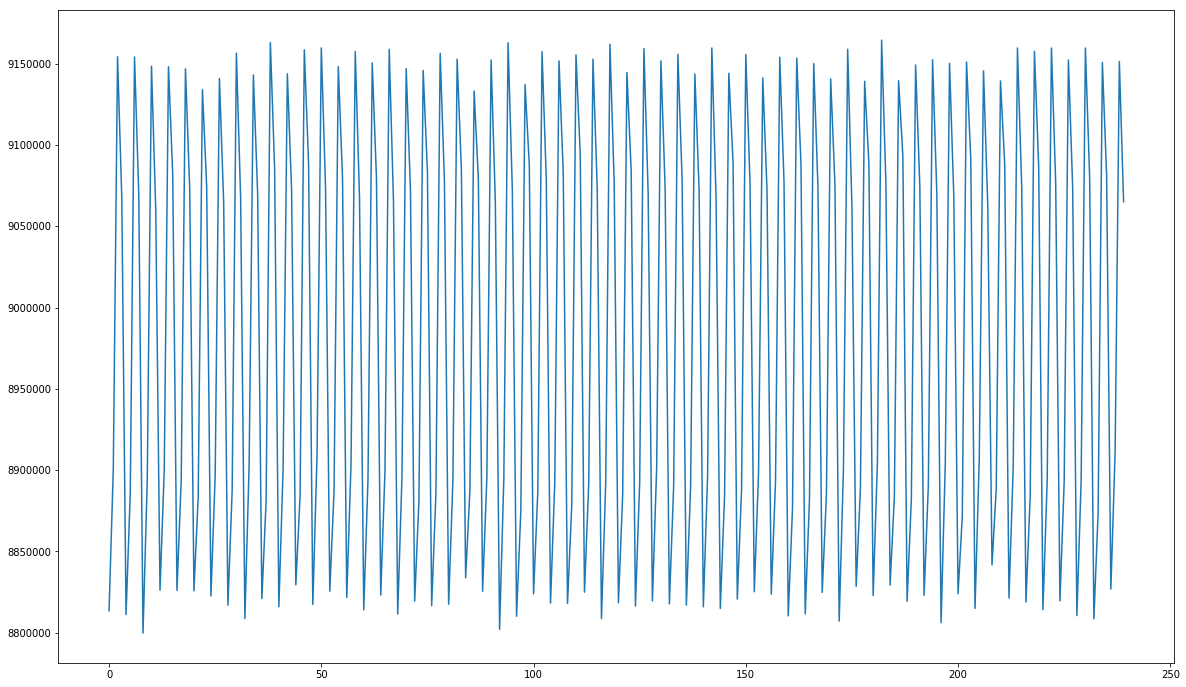

In [382]:
scaled = scale(demod_short['demod'], lines_cadj[0], lines_cadj[1], outwidth)
#scaled = scale(demod_short['demod'], lines_adj1[0], lines_adj1[1], outwidth)
#plt.plot(scaled)
plt.plot(scaled[140:380])

>-10db crossing at  3.57954545455 -16.2154159716
>-3db crossing at  3.57954545455 -16.2154159716
peak at  3.57954545455 0.0 250.212889805
<-3db crossing at  3.63920454545 -14.4825171635
<-10db crossing at  3.63920454545 -14.4825171635


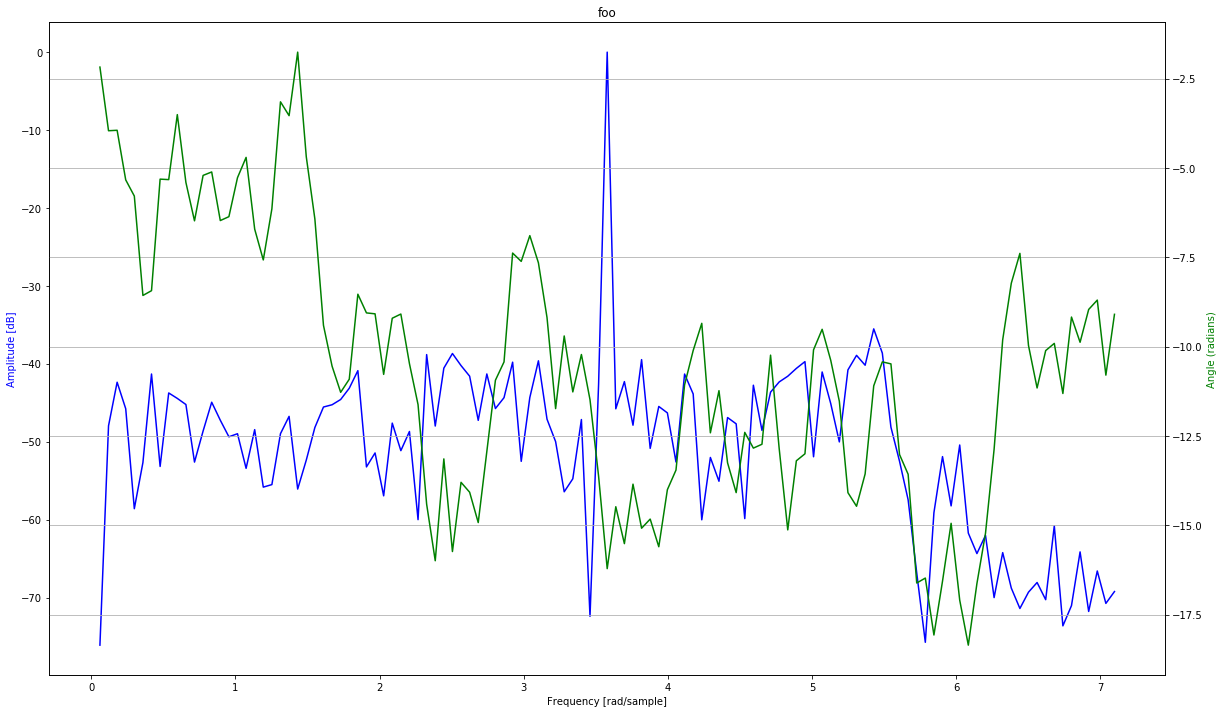

In [383]:
# new routine that needs to be buttoned up for fft burst analysis :)

h = np.fft.fft(scaled[140:380])
h = h[:len(h)//2]
freq = 2 * 315 / 88
w = np.arange(0, freq, freq / len(h))

h = h[1:200]
w = w[1:200]

angles = np.unwrap(np.angle(h))

db = 20 * np.log10(abs(h))
db -= np.max(db)
above_m3 = None
for i in range(1, len(w)):
    if (db[i] >= -10) and (db[i - 1] < -10):
        print(">-10db crossing at ", w[i], angles[i]) 
    if (db[i] >= -3) and (db[i - 1] < -3):
        print(">-3db crossing at ", w[i], angles[i])
        above_m3 = i
    if (db[i] < -3) and (db[i - 1] >= -3):
        if above_m3 is not None:
            peak_index = np.argmax(db[above_m3:i]) + above_m3
            print("peak at ", w[peak_index], db[peak_index], (angles[i] % tau) / (np.pi / 180))
        print("<-3db crossing at ", w[i], angles[i]) 
    if (db[i] >= 3) and (db[i - 1] < 3):
        print(">3db crossing at ", w[i], angles[i]) 
    if (db[i] <= -10) and (db[i - 1] > -10):
        print("<-10db crossing at ", w[i], angles[i]) 

fig, ax1 = plt.subplots(1, 1, sharex=True)
ax1.set_title('foo')

ax1.plot(w, db, 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

#return 20 * np.log10(abs(h))

ax2 = ax1.twinx()
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')

plt.grid()
plt.axis('tight')
plt.show()



In [384]:
270-33

237

In [385]:
w[41], db[41], w[90], db[90]

(2.5056818181818183,
 -38.682020587145615,
 5.4289772727272734,
 -35.520609254522498)

In [376]:
np.argmax(db[60:])

30

In [162]:
(35.853 % tau) / (np.pi / 180)

254.2255828825406

<-3db crossing at  2.5390625
>-3db crossing at  12.5


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


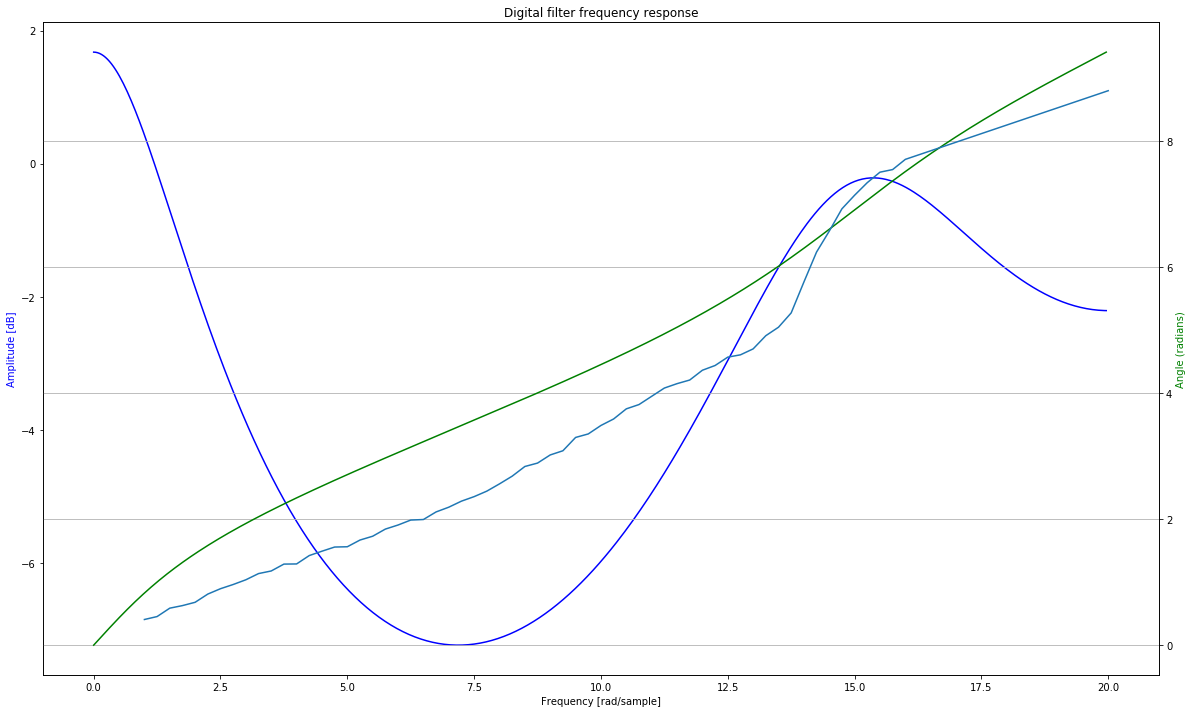

In [481]:
cut = 4
cutend = len(ffreq)-0
_level = 1
_shift = -.00
dimb = 1
dima = 3
[fb, fa] = fdls.FDLS(dimb, dima, ffreq[cut:cutend], np.ones_like(ffreq[cut:cutend]), fphase[cut:cutend]*_level, shift=_shift)
doplot(fb, fa, extra = [filterdata[cut:cut2].hz / 1000000, fphase[cut:cut2]*_level])

<-3db crossing at  2.0703125
>-3db crossing at  13.125


/home/cpage/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


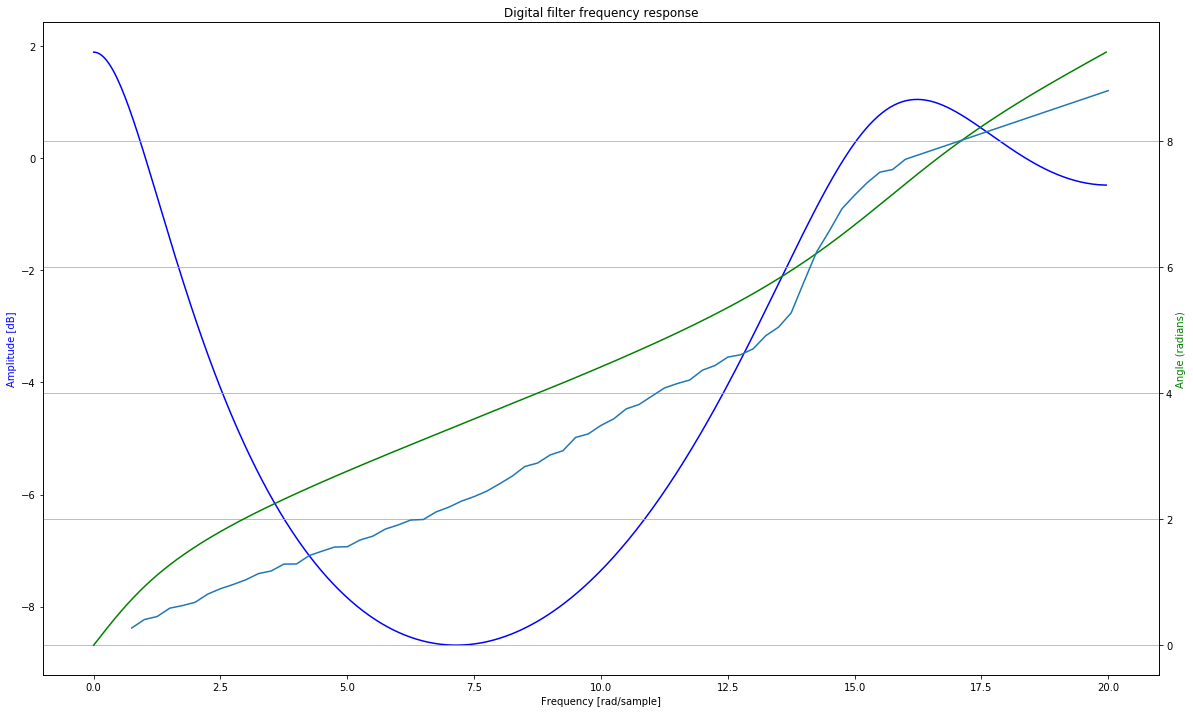

In [333]:
cut = 3
cutend = len(ffreq)-1
_level = 1
_shift = .1
dimb = 1
dima = 3
[fb, fa] = fdls.FDLS(dimb, dima, ffreq[cut:cutend], np.ones_like(ffreq[cut:cutend]), fphase[cut:cutend]*_level, shift=_shift)
doplot(fb, fa, extra = [filterdata[cut:cut2].hz / 1000000, fphase[cut:cut2]*_level])

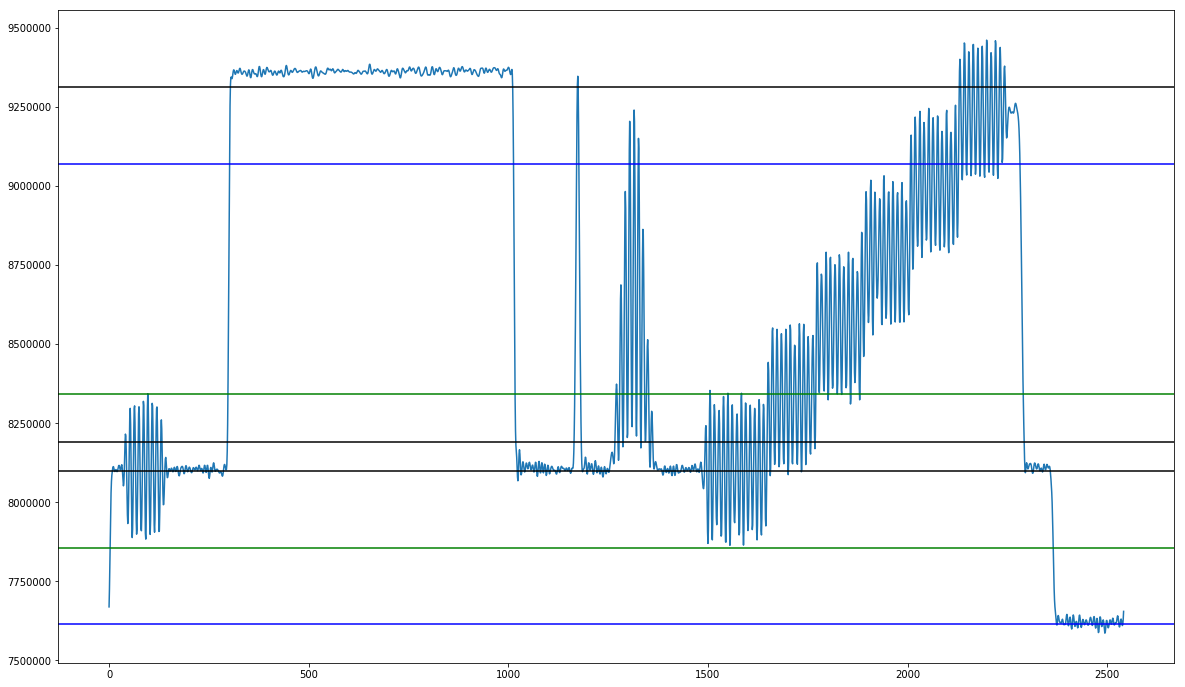

In [1525]:
lineplot(bar0, filterset)


In [1518]:
# need to trust the gaps from filterset_short, 512 is too small to recompute!
params_vshort = copy.deepcopy(params_vshort)
vshort_len = 640
params_vshort['blocklen'] = vshort_len

filterset_vshort = prepare_video_filters(params_vshort)

l = 9
demods_offset = int(filterset_short['dgap'] * 2)

indata_tmp = loaddata(infile, int(prevstart) + int(lineinfo_even[l]) - demods_offset)

indata_vshort = indata_tmp[int(usectopx(11)):int(usectopx(29))][0:vshort_len]
print(len(indata_vshort))
demod_vshort, fft_phase1, fft_phase2 = dodemod(filterset_vshort, indata_vshort, return_fft=True) #[demods_offset:]
demod_vshort = demod_vshort[demods_offset:]

640
102
(640,)
640


/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


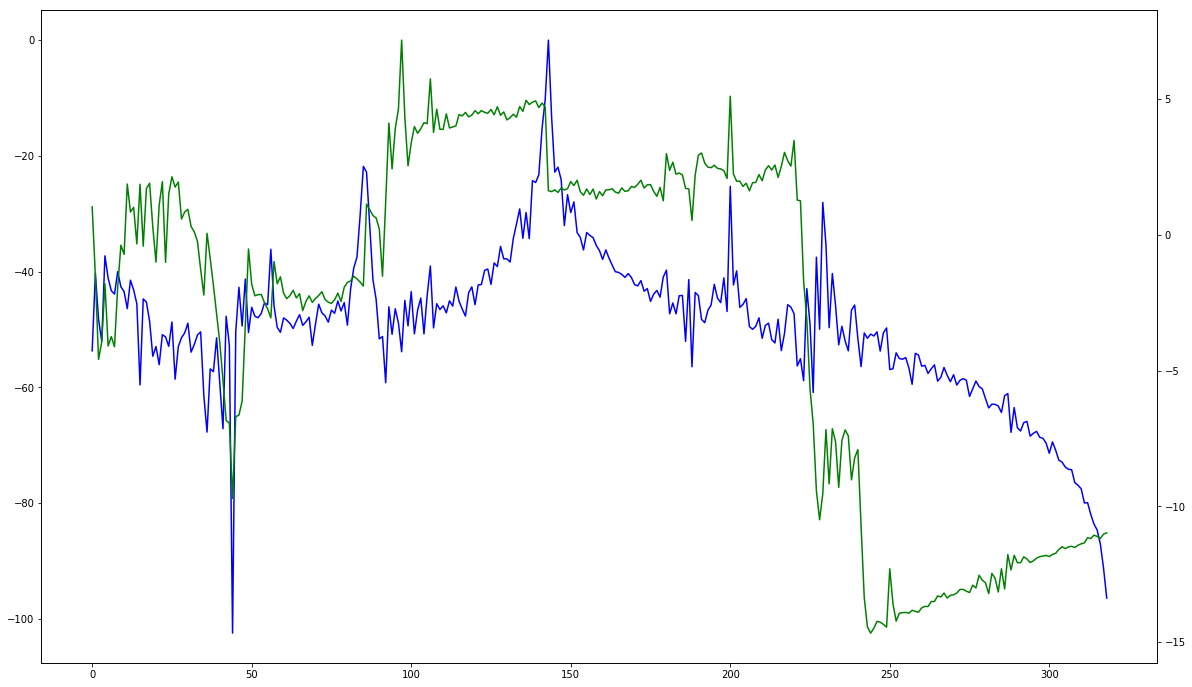

In [1519]:
vshort_lenh = vshort_len // 2
o = 0
fig = plt.figure()
h = np.fft.fft(indata_vshort)
h = fft_phase1

level = 20 * np.log10(abs(h[0:vshort_lenh]))
level -= np.max(level)
ax1 = fig.add_subplot(111)
plt.plot(level[1:vshort_lenh], 'b')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))[0:vshort_lenh]
plt.plot(angles[1:vshort_lenh], 'g')


In [1511]:
#print(np.argmax(level) * (filterset['freq'] / 512))
main_loc = np.argmax(level[90:vshort_lenh]) + 90
main = main_loc * (filterset['freq'] / vshort_len)
main - filterset['fsc_mhz']

sblow = main - filterset['fsc_mhz']
sblow_loc = sblow /(filterset['freq'] / vshort_len)
sbhigh = main + filterset['fsc_mhz']
sbhigh_loc = sbhigh /(filterset['freq'] / vshort_len)

print(main, sblow, sbhigh, main_loc, sblow_loc, sbhigh_loc)

sblow_loc = int(np.round(sblow_loc))
sbhigh_loc = int(np.round(sbhigh_loc))
print(level[sblow_loc], level[sbhigh_loc])

#-23.3597714223 -27.0310163822 - no adjustment

9.0 5.42045454545 12.5795454545 144 86.7272727273 201.272727273
-23.4330430497 -24.1811704982


In [1512]:

angles[sblow_loc-1:sblow_loc+2], angles[main_loc-1:main_loc+2], angles[sbhigh_loc-1:sbhigh_loc+2]

(array([ 5.8465414 ,  8.78998785,  8.51975114]),
 array([ 13.15337106,  10.06977062,  10.03834162]),
 array([ 10.75765999,   8.16936535,  11.12813675]))

In [748]:
# no adj
# array([-5.73431915, -2.74123709, -2.94113885]),
# array([ 4.96126604,  1.85284031,  1.79238869]),
# array([ 0.91108357,  3.00971801,  0.54677654]))
angles[sblow_loc-1:sblow_loc+2], angles[main_loc-1:main_loc+2], angles[sbhigh_loc-1:sbhigh_loc+2]

(array([-5.73431915, -2.74123709, -2.94113885]),
 array([ 4.96126604,  1.85284031,  1.79238869]),
 array([ 0.91108357,  3.00971801,  0.54677654]))

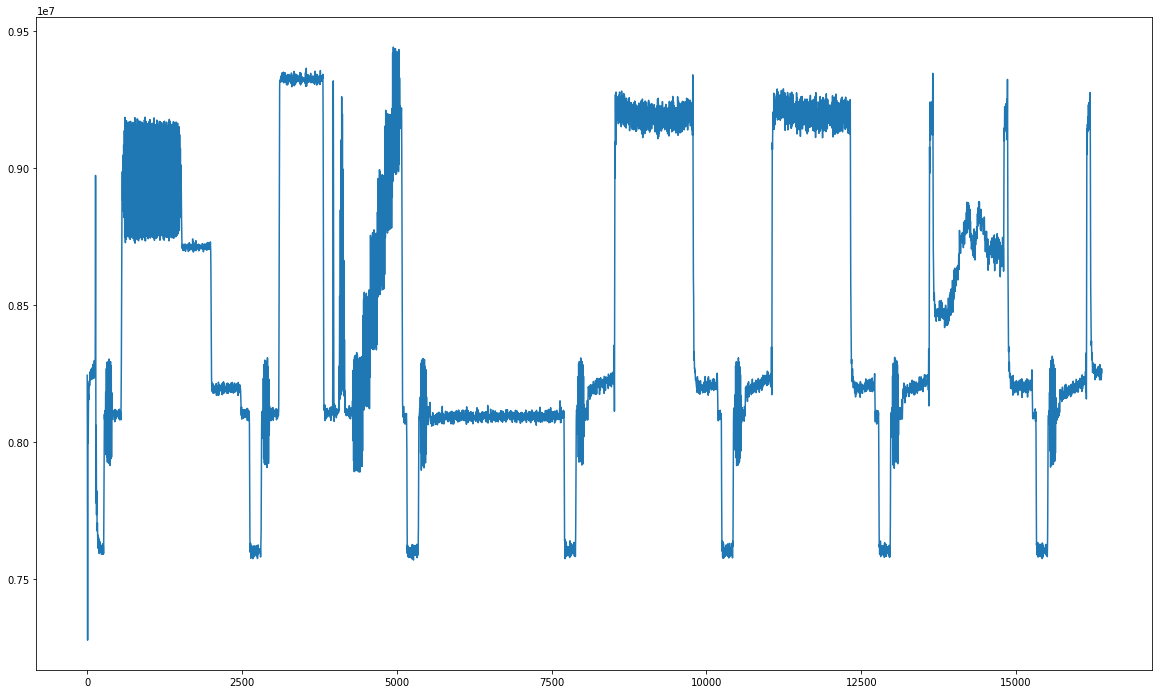

In [368]:
#plt.plot(dodemod(filterset, indata_tmp)['demod'][int(filterset['dgap']):int(filterset['dgap'])+3000])
plt.plot(dodemod(filterset, indata_tmp)['demod'])

In [161]:
lo1[l], lineinfo_odd[l], hztoire(frame['demod'][754960])

(1339812.1894933425, 1339814.1164469707, -23.766467899807346)

In [166]:
calczc(frame['demod'], 1339810.1894933425, iretohz(-20), 80) 

1339812.1894933425

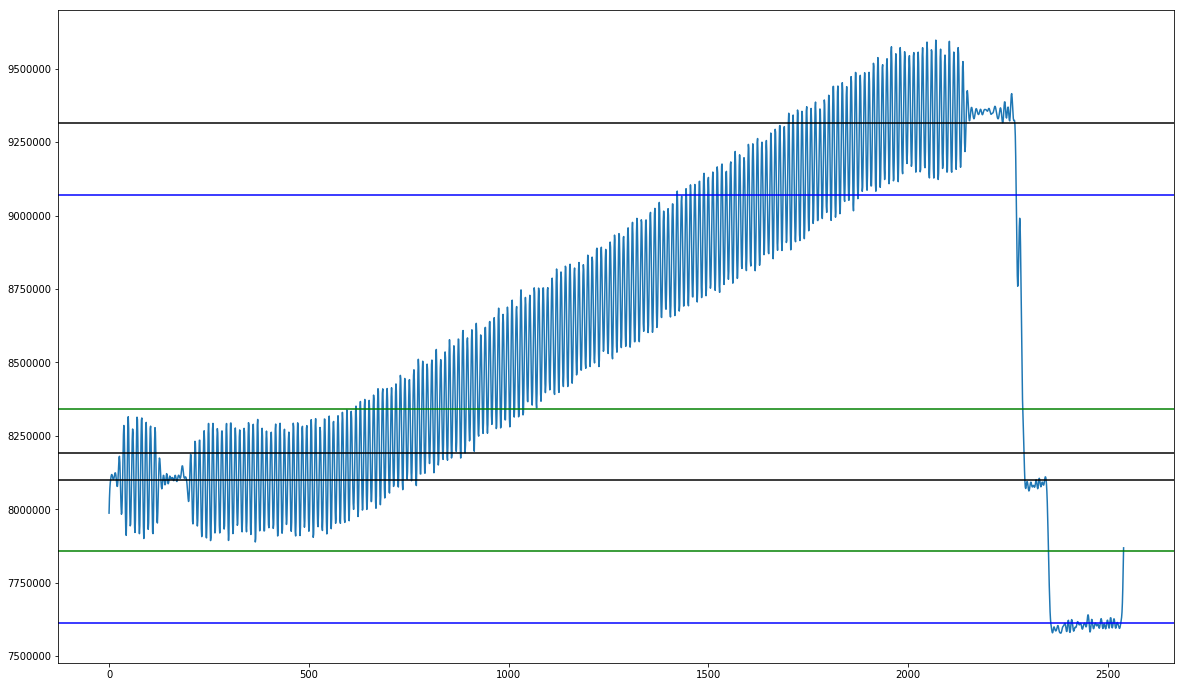

In [164]:
l = 240
#foo0 = foo
foo = frame['demod'][int(lineinfo_odd[l]):int(lineinfo_odd[l+1])]

#lineplot(foo0, filterset)
lineplot(foo, filterset)

In [ ]:
# full output code follows

In [ ]:
outfsc = 4
outwidth = int(outfsc * 227.5)

#d, rdata = findfirstframe(infile, 1024*1024*10400)
d, rdata = findfirstframe(infile, 1024*1024*0)

print(d)

start = d - int(50 * filterset['line_px'])

outfd = open('tmp.tbc', 'wb')

for f in range(0,90):
    frame = demod(infile, start, start + int(650 * filterset['line_px']), filterset, needmtf)
    fs = findsync(frame['demod_sync'], 0)
    print(fs)

    ilinepx = int(filterset['line_px'])

    syncloc1, firstfield, line1 = findsync(frame['demod_sync'], 0)
    print(syncloc1, firstfield, line1)

    # need a margin before sync peak
    start1 = syncloc1 - int(15 * filterset['line_px'])
    print(start, start1)
    lines_odd, lineinfo_odd, lines_odd_cburst = buildfield(frame, start1, outfsc=outfsc)
    processphillipscode(frame, lineinfo_odd)
    
    syncloc2, secondfield, line2 = findsync(frame['demod_sync'], int(lineinfo_odd[-20]))
    print(syncloc2, secondfield, line2)

    start2 = syncloc2 - int(15 * filterset['line_px'])
    lines_even, lineinfo_even, lines_even_cburst = buildfield(frame, start2, outfsc=outfsc)

    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 505, 2):
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = lines_even[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]
        combined[((i + 1) * outwidth):((i + 2) * outwidth)] = lines_odd[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]

    #calcsnr(frame['demod'][int(lineinfo_even[1]+400):int(lineinfo_even[1]+1600)]), calcsnr(frame['demod'][int(lineinfo_even[2]+400):int(lineinfo_even[2]+1600)])    
    output_fullframe, output_cropped = formatoutput(combined, lines_odd_cburst, lines_even_cburst)
    
    outfd.write(output_cropped)
    
    start = start + int(lineinfo_even[-30])
    print(start)

In [ ]:
len(frame)

In [ ]:
int(650 * filterset['line_px'])

In [ ]:
cut = frame['demod'][int(lineinfo_even[i]):int(lineinfo_even[i+1])]

In [ ]:
drawdata(output_fullframe, outwidth, 506, hscale=2, vscale=2)

In [ ]:
# run through comb-ntsc and png conversion.
# (NOTE:  motion detection isn't working right yet ;) )

fd = open('zone3d-27.png', 'rb')
image = fd.read()
IPython.display.Image(image)

In [577]:
indata = loaddata(infile, 1024 * 1024 * 5000)

In [579]:
np.min(indata), np.max(indata)

(-26880, 29312)

>-10db crossing at  2.95166015625
>-3db crossing at  3.408203125
peak at  8.26171875 -1.37705291733e-05
<-3db crossing at  13.4985351562


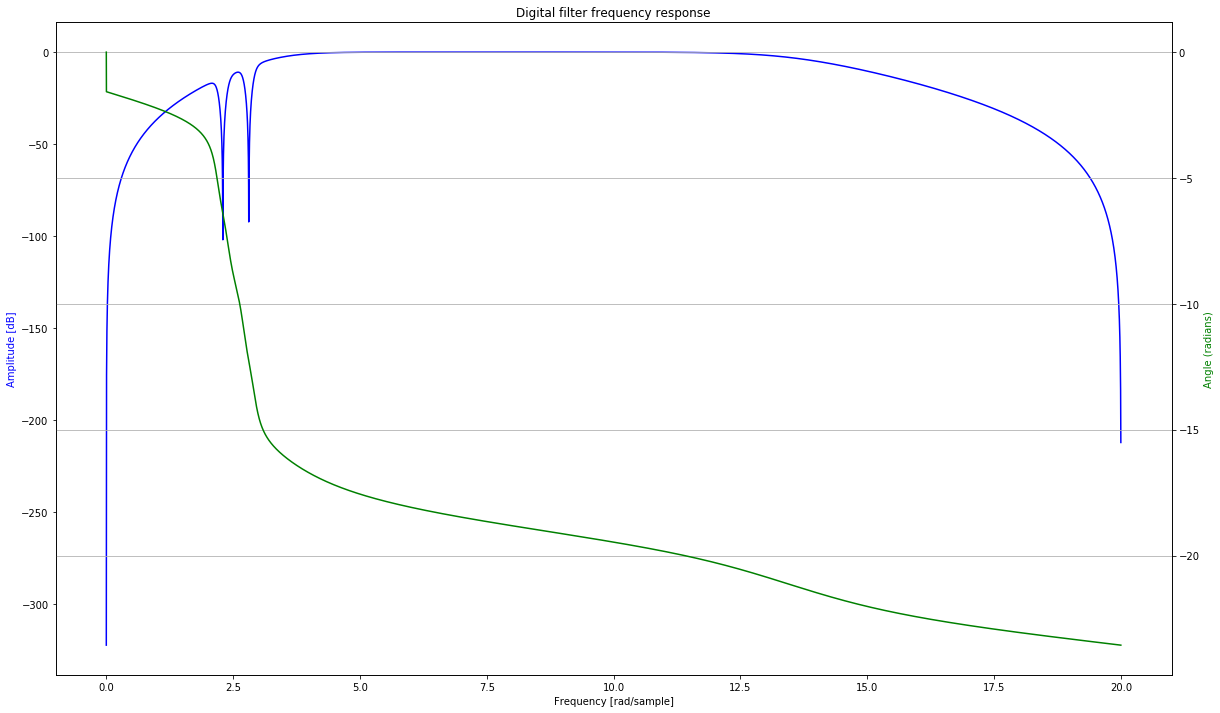

In [812]:
def plotfilt(filterset, key, power = 1.0, extra = None):
    # take the first half of the FFT multiplier
    h = filterset[key] ** power
    h = h[0:len(h)//2]
    
    freq = filterset['freq'] / 2
    w = np.arange(0, freq, freq / len(h))

    db = 20 * np.log10(abs(h))
    above_m3 = None
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i]) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i])
            above_m3 = i
        if (db[i] < -3) and (db[i - 1] >= -3):
            if above_m3 is not None:
                peak_index = np.argmax(db[above_m3:i]) + above_m3
                print("peak at ", w[peak_index], db[peak_index])
            print("<-3db crossing at ", w[i]) 
        if (db[i] >= 3) and (db[i - 1] < 3):
            print(">3db crossing at ", w[i]) 
    
    fig, ax1 = plt.subplots(1, 1, sharex=True)
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, db, 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')
    
    #return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')

    if extra is not None:
        plt.plot(*extra)
    
    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return None


foo = plotfilt(filterset, 'FRFVideo', 1.0)

In [799]:
foo

array([ -0.08729611,  -0.08729589,  -0.08729522, ...,  11.19812053,
        11.19812718,  11.19813117])

In [805]:
filterset.keys()

dict_keys(['freq', 'blocklen', 'system_name', 'audio_lfreq', 'audio_rfreq', 'analog_audio', 'fsc_mhz', 'line_period', 'hz_ire', 'videorf_sync', 'videorf_0ire', 'videorf_7.5ire', 'videorf_100ire', 'ire_min', 'ire_max', 'deemp', 'audio_filtwidth', 'audio_filtorder', 'vbpf', 'vbpf_order', 'vlpf_freq', 'vlpf_order', 'hilbert_filter_terms', 'freq_hz', 'line_px', 'FRFVideo', 'Fcutl', 'Fcutr', 'Fhilbert', 'Fdd', 'Fmtf', 'Fvideo_lpf', 'Fdeemp', 'Femp', 'FVideo', 'F0_5', 'FVideo05', 'Fburst_len', 'Fburst_delay', 'Fburst', 'imglen', 'FVideoBurst', 'FPsync', 'dgap', 'dgap_05', 'dgap_burst'])